In [ ]:
!pip install tensorflow tensorflow-io matplotlib pydub torchutils -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 41.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
from google.colab import files
import numpy as np
import pandas as pd
import os
import librosa as lr
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init
from datetime import datetime
import torch.optim as optim
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torchsummary import summary

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
subdir = "gdrive/My Drive/Deep learning/data set progetto"

In [ ]:
classified_data = pd.read_csv(os.path.join(subdir, 'data.csv'))

In [ ]:
from glob import glob
subdir = "gdrive/My Drive/Deep learning/data set progetto/audio"
subdir2 = "gdrive/My Drive/Deep learning/data set progetto/Audio2"
subdir3 = "gdrive/My Drive/Deep learning/data set progetto/audio4"
classified_data = pd.read_csv(os.path.join('gdrive/My Drive/Deep learning/data set progetto/', 'data.csv'))
our_data=glob("gdrive/My Drive/Deep learning/data set progetto/audio/*.wav")
our_data2=glob("gdrive/My Drive/Deep learning/data set progetto/Audio2/*.wav")
our_data3=glob("gdrive/My Drive/Deep learning/data set progetto/audio4/*.wav")

nome_file=[]
label=[]
for i in our_data:
  for j in classified_data['nome_file']:
    if i==os.path.join(subdir, j):
      path = subdir + '/' + i[54:]
      nome_file.append(path)
      label.append(str(list(classified_data[classified_data['nome_file']==j]['label'])))


for i in our_data2:
  for j in classified_data['nome_file']:
    if i==os.path.join(subdir2, j):
      path = subdir2 + '/' + i[55:]
      nome_file.append(path)
      label.append(str(list(classified_data[classified_data['nome_file']==j]['label'])))

for i in our_data3:
  for j in classified_data['nome_file']:
    if i==os.path.join(subdir3, j):
      path = subdir3 + '/' + i[55:]
      nome_file.append(path)
      label.append(str(list(classified_data[classified_data['nome_file']==j]['label'])))

data={'nome_file':nome_file, 'label':label}
df = pd.DataFrame(data)

In [ ]:
labelencoder=LabelEncoder()
y=np.array(df['label'].tolist())
labels = to_categorical(labelencoder.fit_transform(y))

## BATCH DATALOADER

In [ ]:
class AudioUtil():

  # Load an audio file. Return the signal as a tensor and the sample rate

  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

In [ ]:
class SoundDS():
  def __init__(self, df, labels):
    self.df = df
    self.labels = labels

  # Number of items in dataset

  def __len__(self):
    return len(self.df)


  # Get i'th item in dataset

  def __getitem__(self, idx):
    # Absolute file path of the audio file
    audio_file = self.df.loc[idx, 'nome_file']

    # Get the Class ID
    class_id = self.labels[idx]

    aud = AudioUtil.open(audio_file)
    sgram = AudioUtil.spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None)
    return sgram, class_id, audio_file

In [ ]:
myds = SoundDS(df, labels)
# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=True)

In [ ]:
next(iter(train_dl))[0].shape

torch.Size([16, 2, 64, 862])

In [ ]:
class AudioClassifier (nn.Module):

    def __init__(self, input_shape, num_classes):
        super(AudioClassifier, self).__init__()
        conv_layers = []

        # First Convolution Block
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) # CAMBIATO DA 32 A 64
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)

        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=num_classes)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)

    # Forward pass computations

    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.size(0), -1)

        # Linear layer
        x = self.lin(x)

        return x


# Create the model and put it on the GPU if available
myModel = AudioClassifier(([16,2,64,862]) , 15)


Epoch: 0, Loss: 2.54,  Training Accuracy: 0.21
Epoch: 1, Loss: 2.06,  Training Accuracy: 0.47
Epoch: 2, Loss: 1.60,  Training Accuracy: 0.59
Epoch: 3, Loss: 1.25,  Training Accuracy: 0.67
Epoch: 4, Loss: 0.96,  Training Accuracy: 0.75
Epoch: 5, Loss: 0.80,  Training Accuracy: 0.79
Epoch: 6, Loss: 0.66,  Training Accuracy: 0.84
Epoch: 7, Loss: 0.57,  Training Accuracy: 0.85
Epoch: 8, Loss: 0.50,  Training Accuracy: 0.88
Epoch: 9, Loss: 0.44,  Training Accuracy: 0.91
Epoch: 10, Loss: 0.39,  Training Accuracy: 0.92
Epoch: 11, Loss: 0.39,  Training Accuracy: 0.93
Finished Training


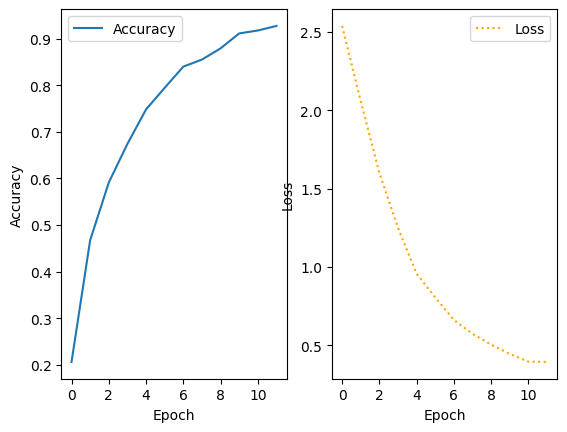

In [ ]:
def training(model, train_dl, num_epochs):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  avg_loss_list=[]
  acc_list=[]
  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, (inputs, labels, file_path) in enumerate(train_dl):

        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        optimizer.zero_grad()

        outputs = myModel(inputs)

        loss = criterion(outputs, labels) # labels
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

        _, prediction = torch.max(outputs,1)

        rows, cols = torch.where(labels == 1)

        correct_prediction += (prediction == cols).sum().item()
        total_prediction += prediction.shape[0]


    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    avg_loss_list.append(avg_loss)
    acc = correct_prediction/total_prediction
    acc_list.append(acc)
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f},  Training Accuracy: {acc:.2f}')


  print('Finished Training')


  plt.subplot(1, 2, 1)
  plt.plot(acc_list, label='Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  ax = plt.gca()
  ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

  plt.subplot(1, 2, 2)
  plt.plot(avg_loss_list, ':', color='orange', label='Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  ax = plt.gca()
  ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
  plt.show()


num_epochs=12   # Just for demo, adjust this higher.
prova = training(myModel, train_dl, num_epochs)

In [ ]:
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  predictions = []
  labels_list = []
  file_paths = []

  # Disable gradient updates
  with torch.no_grad():
    for i, (inputs, labels, file_path) in enumerate(val_dl):

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      rows, cols = torch.where(labels == 1)

      # Count of predictions that matched the target label
      correct_prediction += (prediction == cols).sum().item()
      total_prediction += prediction.shape[0]

      # Append the predictions, assigned labels and file paths
      predictions.append(prediction.cpu().numpy())
      labels_list.append(cols.cpu().numpy())
      file_paths.append(file_path)

  # Concatenate the saved predictions, assigned labels and file paths
  predictions = np.concatenate(predictions)
  labels_list = np.concatenate(labels_list)
  file_paths = np.concatenate(file_paths)

  # Print the file path, assigned label and prediction for each file
  for i in range(len(file_paths)):
    label_str = labelencoder.inverse_transform([labels_list[i]])[0]
    label_str = label_str.strip('[]')
    label_str = label_str.replace("'", "")

    pred_str = labelencoder.inverse_transform([predictions[i]])[0]
    pred_str = pred_str.strip('[]')
    pred_str = pred_str.replace("'", "")


    print(f'File path: {file_paths[i]}, Label: {label_str}, Prediction: {pred_str}, Guessed correctly: {label_str==pred_str}')

  acc = correct_prediction/total_prediction
  print('\n')
  print(f'Accuracy: {acc:.2f}')

inference(myModel, val_dl)

In [ ]:
print(myModel)

AudioClassifier(
  (conv1): Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu1): ReLU()
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu4): ReLU()
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ap): AdaptiveAvgPool2d(output_size=1)
  (lin): Linear(in_features=64, out_features=15, bias=True)
  (conv): Sequential(
    (0): Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, mome

In [ ]:
myModel.parameters()

<generator object Module.parameters at 0x7f83692e0f20>

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
num_parameters = count_parameters(myModel)
print("Number of trainable parameters: ", num_parameters)

Number of trainable parameters:  25927


In [ ]:
save_path = 'gdrive/My Drive/Deep learning/data set progetto/model_spectrogram.pt'  # Update with your desired path and model name
#myModel.save(save_path)
torch.save({'model_spectrogram': myModel.state_dict()}, save_path)